# Use case: Sales time series descriptive analytics

*Date: 20/04/2020*  
*Place: Antwerp, Belgium*  
*Data scientist: Anna Sukhareva*  
*Contact: anna@linefeed.be*  

## Table of Contents
1 : Business Understanding  
2 : Data Requirements  
3 : Data Collection  
4 : Data Understanding  

## 1. Business Understanding  
**Problem:**  There is a network comprising 60 retail shops, selling about 20 K unique items.
**Question:** What can we tell about sales?  

## 2. Data reguirements:
Source: Internal data  
Format: csv  
Content:  
- items,   
- items categories,  
- shops,  
- sales.  

## 3. Data collecion

In [ ]:
#libraries

# computation
import numpy as np
import pandas as pd
import itertools

# visualization
import matplotlib.pyplot as plt
%matplotlib inline

# statistic
from pylab import rcParams
import statsmodels.api as sm

pd.set_option('display.float_format', lambda x: '%.2f' % x)
import warnings
warnings.filterwarnings("ignore")

print('Imported')

In [ ]:
# loading data

items = pd.read_csv(r'.\202004SalesPrediction.data\items.csv',  dtype={
    'item_name': 'str', 
    'item_id': 'int32', 
    'item_category_id': 'int32'
    }
    )
item_categories = pd.read_csv(r'.\202004SalesPrediction.data\item_categories.csv', dtype={
    'item_category_name': 'str', 
    'item_category_id': 'int32'
    }
    )
shops = pd.read_csv(r'.\202004SalesPrediction.data\shops.csv', dtype={
    'shop_name': 'str', 
    'shop_id': 'int32'
    }
    )
test = pd.read_csv(r'.\202004SalesPrediction.data\test.csv', dtype={
    'ID': 'int32', 
    'shop_id': 'int32', 
    'item_id': 'int32'
    }
    )
print('Loaded')

In [ ]:
sales = pd.read_csv(r'.\202004SalesPrediction.data\sales_train.csv', parse_dates=['date'], dtype={
    'date': 'str', 
    'date_block_num': 'int32', 
    'shop_id': 'int32', 
    'item_id': 'int32', 
    'item_price': 'float32', 
    'item_cnt_day': 'int32'
    }
    )
print('Loaded')

In [ ]:
# join datasets

train = sales.join(items, on='item_id', rsuffix='_').join(shops, on='shop_id', rsuffix='_').join(item_categories, on='item_category_id', rsuffix='_').drop(['item_id_', 'shop_id_', 'item_category_id_'], axis=1)
train.head()

## 4. Data understanding

In [ ]:
print(train.shape)

In [ ]:
train.head()

In [ ]:
train.describe()

### How different is assortiment in shops?

In [ ]:
assortment = sales[['shop_id', 'item_id']]
a = assortment.groupby('shop_id')['item_id'].nunique().reset_index(name='uniqueCounts')
a.head()

In [ ]:
a.uniqueCounts.hist()
plt.xlabel('Unique item_id, counts')
plt.ylabel('Number of shops, counts')
plt.title('How much unique items shops had over time period?')
plt.show()

###  Which items are not sold in no one shop?

In [ ]:
# Which items are not sold in no one shop?

itemsAll = set(items.item_id.tolist())
itemsSold = set(sales.item_id.unique().tolist())
itemsNonSold = list(itemsAll - itemsSold)
itemsNonSold.sort()

print(len(itemsNonSold), 'items_id were never sold in no one shoip, namely items_id: ', itemsNonSold[:11], ' and others')

In [ ]:
pivoted = sales.pivot_table(index='shop_id', columns='item_id', values='item_cnt_day', aggfunc=np.sum)

itemsIdNumberOFShopsSoldIt = pivoted.count().rename_axis('item_id').reset_index(name='TotalShopsThatSoldIt')
itemsIdNumberOFShopsSoldIt = itemsIdNumberOFShopsSoldIt.sort_values(by='TotalShopsThatSoldIt', ascending=False)
itemsIdNumberOFShopsSoldIt

In [ ]:
itemsIdNumberOFShopsSoldIt.TotalShopsThatSoldIt.plot.box(grid='True')
plt.ylabel('Number shops that sold the item')
plt.title('Overview: In how many shops are items sold?')
plt.show()

# Mediana - items are sold in ~15 shops
# 25% items are sold ~ in 4 shops
# 75% of items are sold in ~ 34 shops

In [ ]:
itemsIdNumberOFShopsSoldIt.TotalShopsThatSoldIt.hist()
plt.xlabel('Number shops that sold the item')
plt.ylabel('items_id, count')
plt.title('Overview: In how many shops are items sold?')
plt.show()

In [ ]:
pivoted['UniqueItemIdSold'] = pivoted.count(axis=1)

pivoted.UniqueItemIdSold.hist()
plt.xlabel('Unique Items_id, count')
plt.ylabel('Shops, count')
plt.title('Overview: How many unique items_id are sold in shops?')
plt.show()

In [ ]:
pivoted.UniqueItemIdSold.plot.box(grid='True')
#plt.ylabel('Number shops that sold the item')
plt.title('Overview: How many unique items_id are sold in shops?')
plt.show()

25% shops (~15) have under ~4000 unique items_id  
75% shops (~45) have under ~9000 unique items_id  

About 26 shops sold 3.1-9K unique item_id.  
Mediana: 7K unique items_id

### Do all shops have same prices for same items_id?

In [ ]:
prices = sales.pivot_table(index='shop_id', columns='item_id', values='item_price')

# picking min & max prices for each item
def minMax(x):
    return pd.Series(index=['min','max'],data=[x.min(),x.max()])
prices = prices.apply(minMax)
prices = prices.T

# creating a column with difference in min & max prices:
prices['differentProcent'] = round(abs(prices['min']*100/prices['max'] - 100))
prices['differentProcent'] = prices['differentProcent'].astype(int)

prices.head()

In [ ]:
print(
prices.loc[prices.differentProcent != 0].shape[0], ' items_id have different prices, ´that is equal to ', round(prices.loc[prices.differentProcent != 0].shape[0] * 100 / prices.shape[0]), ' %'
)

### Sample of pricing policy: item_id = 11865

In [ ]:
item11865 = sales.loc[sales.item_id == 11865]
print(
'Total sales:' , item11865.item_cnt_day.sum(),
', in total shops:' , item11865.loc[item11865.item_price == 0.1].shop_id.nunique()
)

In [ ]:
item11865.item_price.hist()
plt.title('How differ price for item_id = 11865?')
plt.show()

In [ ]:
item11865.item_price.value_counts().head()

Sample, result:  
- 233 times sold,  
- price: from 0.1 to 729,  
- 140 sales with price 0.1, over 34 different shops.    
Conclusion: discount policy.

### How can we describe a discount policy?

In [ ]:
print(
prices.loc[prices.differentProcent != 0].shape[0], 'unique items_id were sold with discount:',  '\n',
prices.loc[prices.differentProcent == 100].shape[0], ' item_id were sold with max discount =', prices.loc[prices.differentProcent != 0].differentProcent.max() , '%', '\n',
'in', sales.loc[sales.item_price < 1].shop_id.nunique(), 'shops', '\n',
sales.loc[sales.item_price < 0].shape[0], 'item were sold with negative price = -1'
)

In [ ]:
prices.loc[prices.differentProcent != 0].differentProcent.plot.box()
plt.title('How differ price for item_id in shops, % ?')
plt.show()

Cocnlusion:  
- There is discount policy,  
- Some items may be sold with 100% discount, that may be an action sort of 'Second item for free'  
- Discount policy:  
    - 35%  - .25 percentile, 
    - ~43%  - mediana,
    -  57%  - .75 percentile,
    - 74% - .9 percentile,
    - outliers - with ~95-100% discount.

### How would you describe a returns policy?

In [ ]:
# How many item_id has been returned at once?

sales.loc[sales.item_cnt_day < 0].item_cnt_day.value_counts()

In [ ]:
# How many returns per shop? 

salesCropped.loc[salesCropped.item_cnt_day < 0].shop_id.value_counts().hist()
plt.xlabel('Quantity of returned items, count')
plt.ylabel('Number of shops, count')
plt.title('Overview: How many returns per shop?')
plt.show()

In [ ]:
# Conclusion

print(
'Returned items:', salesCropped.loc[salesCropped.item_cnt_day < 0].shape[0], '\n',
'Over', salesCropped.loc[salesCropped.item_cnt_day < 0].item_id.nunique(), 'unique item_id', '\n',
'Over' , salesCropped.loc[salesCropped.item_cnt_day < 0].shop_id.nunique(), 'shops', '\n',
'Returned quantity, at once:', salesCropped.loc[salesCropped.item_cnt_day < 0].item_cnt_day.unique(),'\n',
'Most returns (mediana) have', abs(salesCropped.loc[salesCropped.item_cnt_day < 0].item_cnt_day.median()), 'items'
)

### How much wholesale deals?

In [ ]:
sales.item_cnt_day.describe()

In [ ]:
sales.item_cnt_day.plot.box()
plt.show()

In [ ]:
print(
#'80 procent of all deals == 1 pcs, ', '\n',
sales.loc[sales.item_cnt_day > 100].shape[0], 'deals have quaninty over 100 pcs, over', 
sales.loc[sales.item_cnt_day > 100].shop_id.nunique(), 'shops_id'
)

### Overview for each item_id - N shops sold, N sales, N unique prices..

In [ ]:
# Due to computantionally costs to perform the operation, I'm going to take a random 1000 item's to discover
#listItems = list(range(0,22170))

import random
randomItem_id = random.sample(list(range(0, 22170)), 50)  # takes about 30 sec

concatenatedData = []

for each in randomItem_id: 
    concatenatedData.append(
        [
        each, # item_id
        sales.loc[(sales.item_id == each)].shape[0], # salesN = number of sales 
        sales.loc[(sales.item_id == each)].shop_id.nunique(), # shopsN = number of shops
        sales.loc[(sales.item_id == each)].item_price.nunique() # pricesN =   number of prices
        ]
        )

salesPerItem = pd.DataFrame(concatenatedData, columns =['item_id', 'salesN', 'shopsN', 'pricesN']) 
salesPerItem = salesPerItem.loc[salesPerItem.salesN != 0]

salesPerItem.head()

In [ ]:
# Creating a column 'flag' - if item has been sold more than in 1 shop - 1, else == 0

salesPerItem.loc[salesPerItem['shopsN'] == 1, 'ShopsDifferent'] = 0
salesPerItem.loc[salesPerItem['shopsN'] > 1, 'ShopsDifferent'] = 1

# Same shop different prices:
salesPerItem.loc[
    ((salesPerItem['ShopsDifferent'] == 0) & (salesPerItem['pricesN'] != 1) ) & (salesPerItem['salesN'] != 0)
    , 'shopSamePriceDifferent'] = 1

salesPerItem.head()

### Find seasonal patterns or trends

In [ ]:
trainMonthly = train[['date', 'item_price', 'item_cnt_day']]

# calculate revenue
trainMonthly['revenue'] = trainMonthly.item_price* trainMonthly.item_cnt_day

# set date as index
trainMonthly.date = pd.to_datetime(trainMonthly.date)
trainMonthly.set_index('date', inplace=True)

# resample to months
trainMonthly = trainMonthly['revenue'].resample('MS').mean()
trainMonthly.head()

In [ ]:
# check for nulls
trainMonthly.isnull().sum()

In [ ]:
# visualization
trainMonthly.plot(figsize=(20,10))
plt.ylabel('Revenue')
plt.title('Monthly revenue')

plt.show()

In [ ]:
# Extracting trend, season and noice - 'decomposing'

rcParams['figure.figsize'] = 11, 9
decomposition = sm.tsa.seasonal_decompose(trainMonthly, model='additive')
fig = decomposition.plot()
plt.show()

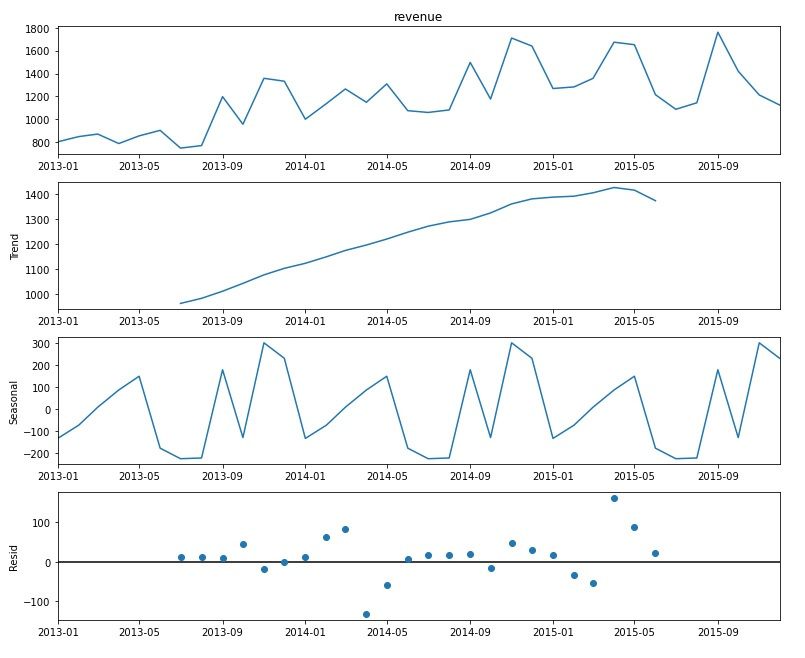

In [13]:
from IPython.display import Image
Image(filename= 'Reatill sale trend decomposing.jpg')

**Conclustion**  
- Trend is going up (here, need to run a statistical test, to confirm the visual observation)  
- Strong trend - september-january sales are up,    
- There are some noice in data, need to be cleaned.  

In [ ]:
End of code.